import library

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Data Preprocessing
"""
Training Data : 以單位長度(seq_length)切成一段RNN的input並append到sequences
Target        : 把Training Data切完的後一位做為target來訓練

假設總共有三個 slice，UE在每個時間點會註冊在其中一個 slice
"""
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences), torch.tensor(targets)

# define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out
    
# define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Training Data

In [20]:
#data = [0, 1, 2, 1, 0, 2, 1, 2, 0, 1]
#data = [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]
data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]

Training

In [21]:
# Model Arguments
input_size = 1
hidden_size = 10
output_size = 3

# define Model
model = LSTMModel(input_size, hidden_size, output_size)
#model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 將輸入資料轉換成模型可用的格式
seq_length = 3
sequences, targets = create_sequences(data, seq_length)

# Training
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(sequences.unsqueeze(2).float())
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [100/1000], Loss: 0.9947842955589294
Epoch [200/1000], Loss: 0.6748256087303162
Epoch [300/1000], Loss: 0.5186578035354614
Epoch [400/1000], Loss: 0.4256175756454468
Epoch [500/1000], Loss: 0.3697912096977234
Epoch [600/1000], Loss: 0.3442348539829254
Epoch [700/1000], Loss: 0.33087578415870667
Epoch [800/1000], Loss: 0.3226562738418579
Epoch [900/1000], Loss: 0.31701064109802246
Epoch [1000/1000], Loss: 0.31288179755210876


Prediction

In [22]:
# data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
# 測試模型
test_data = [1, 1, 2]
with torch.no_grad():
    #print(torch.tensor(test_data))
    #print("unsqueeze", torch.tensor(test_data).unsqueeze(0).unsqueeze(2))

    input_seq = torch.tensor(test_data).unsqueeze(0).unsqueeze(2).float()
    #print(input_seq)
    predicted_slice = torch.argmax(model(input_seq)).item()

print(f'預測的網絡切片為: {predicted_slice}')

預測的網絡切片為: 2


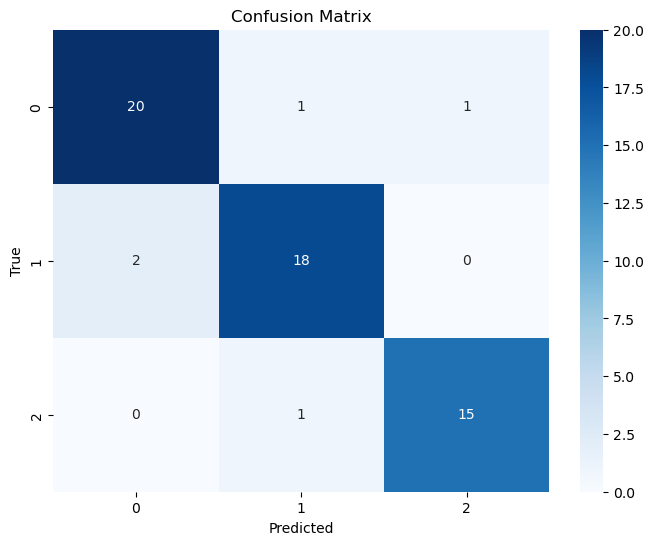

Accuracy: 0.9137931034482759
Precision: 0.9137931034482759
Recall: 0.9137931034482759
F1 Score: 0.9137931034482759


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 測試模型
with torch.no_grad():
    input_seq = torch.tensor(test_data).unsqueeze(0).unsqueeze(2).float()
    predicted_slice = torch.argmax(model(input_seq)).item()

# 評估模型性能
predicted_labels = model(sequences.unsqueeze(2).float()).argmax(dim=1)
true_labels = targets

# 計算混淆矩陣和準確率
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# 顯示混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 顯示評估指標
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
